## **Task 1: Data Preparation – Robust Data Augmentation**

In [20]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
import os

print(os.listdir("/content/drive/MyDrive/PCBData"))

['test.txt', 'trainval.txt', 'group90100', 'group12000', 'group12300', 'group77000', 'group50600', 'group44000', 'group92000', 'group20085', 'group13000', 'group12100', 'group00041']


In [22]:
print(os.listdir("/content/drive/MyDrive/PCBData/group12000/12000"))

['12000187_temp.jpg', '12000068_temp.jpg', '12000136_temp.jpg', '12000102_test.jpg', '12000204_test.jpg', '12000155_test.jpg', '12000171_temp.jpg', '12000038_test.jpg', '12000102_temp.jpg', '12000204_temp.jpg', '12000085_temp.jpg', '12000052_test.jpg', '12000155_temp.jpg', '12000593_test.jpg', '12000119_test.jpg', '12000187_test.jpg', '12000038_temp.jpg', '12000171_test.jpg', '12000017_temp.jpg', '12000001_temp.jpg', '12000068_test.jpg', '12000052_temp.jpg', '12000119_temp.jpg', '12000593_temp.jpg', '12000136_test.jpg', '12000085_test.jpg', '12000001_test.jpg', '12000017_test.jpg']


**Split Data into train/validation**

In [23]:
import shutil #helps you manage files and folders efficiently
import random

In [24]:
#Define Paths
SOURCE_DIR = "/content/drive/MyDrive/PCBData"
TARGET_DIR = "/content/drive/MyDrive/PCBData_split"

TRAIN_RATIO = 0.8  # 80% train, 20% validation

In [25]:
#Create Folder Structure
classes = ["defect", "normal"]

for split in ["train", "val"]: #It creates folders for training and validation data
    for cls in classes: #Inside each split (train, val), it creates class-wise subfolders
        os.makedirs(os.path.join(TARGET_DIR, split, cls), exist_ok=True)

| Part            | Purpose                       |
| --------------- | ----------------------------- |
| `os.path.join`  | Builds correct folder path    |
| `os.makedirs`   | Creates folders               |
| `exist_ok=True` | Avoids duplicate-folder error |


| Filename contains | Label  |
| ----------------- | ------ |
| `_test`           | defect |
| `_temp`           | normal |


In [26]:
#Collect All Images
def get_all_images(source_dir):
    image_paths = []
    for root, _, files in os.walk(source_dir): #os.walk() scans through every folder and file inside source_dir
        for file in files:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(os.path.join(root, file))
    return image_paths

all_images = get_all_images(SOURCE_DIR)
print("Total images found:", len(all_images))

Total images found: 3001


In [27]:
#Split & Copy Images
random.seed(42) #fixes randomness so results are reproducible.
random.shuffle(all_images)

split_index = int(len(all_images) * TRAIN_RATIO) #calculates where to split the dataset based on TRAIN_RATIO.
train_images = all_images[:split_index] #gets the training portion of images.
val_images = all_images[split_index:] #gets the remaining images for validation.

In [28]:
#Copy Images to Train/Val Folders (This function copies images into train/val folders based on their labels)
def copy_images(image_list, split_type):
    for img_path in image_list:
        filename = os.path.basename(img_path)

        if "_test" in filename:
            label = "defect" #If the filename contains _test, the image is labeled defect.
        elif "_temp" in filename:
            label = "normal" #If the filename contains _temp, the image is labeled normal.
        else:
            continue  # skip unknown files

        target_path = os.path.join(TARGET_DIR, split_type, label, filename) #os.path.join(...) builds the destination file path where the image should go.
        shutil.copy(img_path, target_path) #shutil.copy(...) copies the image from its original location to this target folder.

copy_images(train_images, "train")
copy_images(val_images, "val") #Each image is copied to the correct class folder inside train or val.

In [29]:
#Verify Dataset
for split in ["train", "val"]: #The loop goes through train and validation folders.
    print(f"\n{split.upper()} SET") #It prints the dataset split name (TRAIN SET, VAL SET).
    for cls in classes:
        path = os.path.join(TARGET_DIR, split, cls)
        print(cls, ":", len(os.listdir(path))) #os.listdir(path) lists files in that class folder.


TRAIN SET
defect : 1187
normal : 1213

VAL SET
defect : 313
normal : 288


**Training Generator (WITH augmentation)**

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( #generates modified images on the fly to improve model generalization.
    rescale=1./255, #Normalizes pixel values to 0–1
    rotation_range=20, #Randomly rotates images ±20°
    width_shift_range=0.1,
    height_shift_range=0.1, #Randomly shifts images horizontally/vertically
    zoom_range=0.15, #Randomly zooms in/out
    horizontal_flip=True, #Randomly flips images left-right
    brightness_range=[0.8, 1.2], #Randomly changes brightness
    fill_mode="nearest" #Fills missing pixels after transformations
)

**Validation Generator (NO augmentation)**

In [31]:
val_datagen = ImageDataGenerator(
    rescale=1./255
)

**Create Data Loaders**

prepares image data for training and validation using Keras generators

In [32]:
TRAIN_DIR = "/content/drive/MyDrive/PCBData_split/train"
VAL_DIR = "/content/drive/MyDrive/PCBData_split/val" #Paths to train and validation folders

IMG_SIZE = (224, 224) #Resizes all images to 224×224 pixels
BATCH_SIZE = 32 #Number of images per batch during training

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",#Suitable for two-class classification (defect vs normal)
    shuffle=True
) #Loads images from TRAIN_DIR, applies augmentation, shuffles data

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
) #Loads images from VAL_DIR, no augmentation, does not shuffle

Found 2400 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


| Generator  | Shuffle | Reason            |
| ---------- | ------- | ----------------- |
| Train      |  Yes   | Better learning   |
| Validation |  No    | Stable evaluation |


In [33]:
#Verify class mapping
print(train_generator.class_indices)

{'defect': 0, 'normal': 1}


**Visualize the augmented images**

In [34]:
#Get ONE batch from the training generator
# Get one augmented batch
images, labels = next(train_generator) #retrieves one batch of images and labels from the training generator

print("Batch image shape:", images.shape)
print("Batch label shape:", labels.shape)

Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


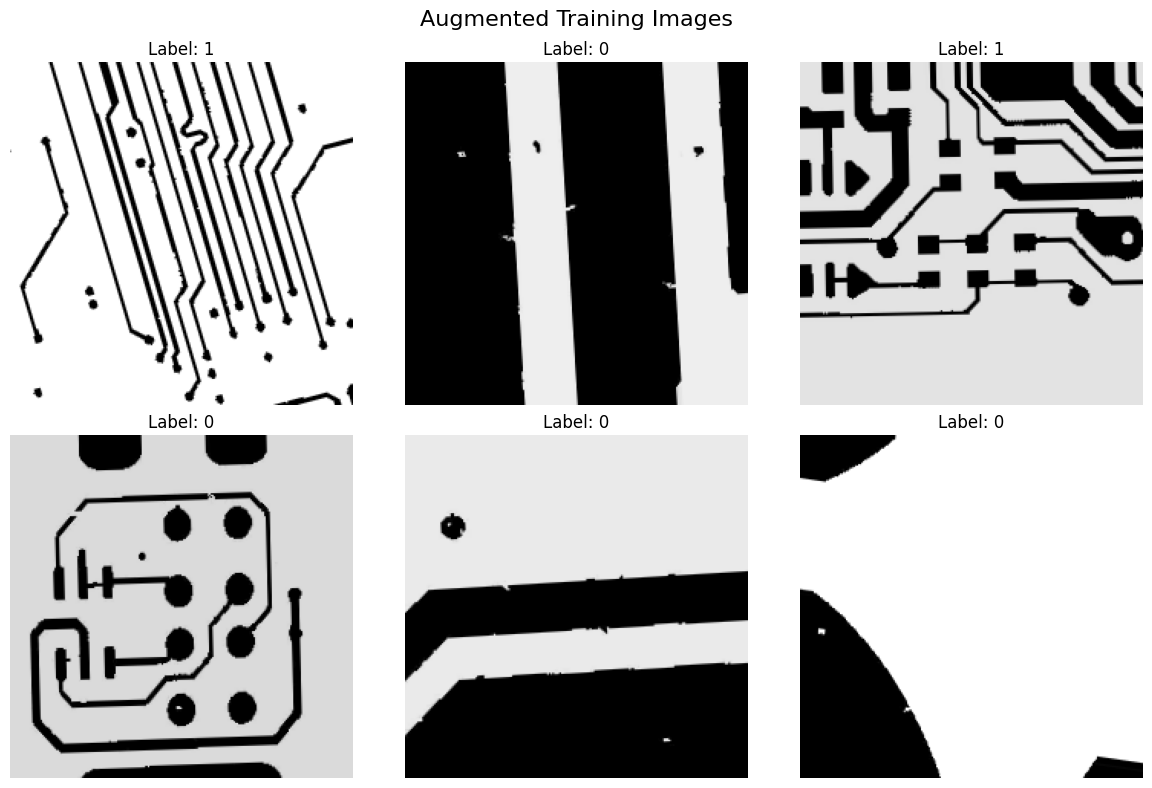

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))

for i in range(6):  # show 6 augmented images
    plt.subplot(2, 3, i + 1)

    # Images are rescaled → convert back to [0,255]
    img = (images[i] * 255).astype("uint8") #.astype("uint8") → Changes data type to unsigned 8-bit integer, standard for images

    plt.imshow(img)
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")

plt.suptitle("Augmented Training Images", fontsize=16)
plt.tight_layout()
plt.show()

##**Task 2: Core Modeling – Transfer Learning**

In [36]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

MobileNetV2 → lightweight, fast, production-friendly

EarlyStopping → stops training if validation loss increases

ModelCheckpoint → saves best model automatically

**Load Pre-trained MobileNetV2**

In [37]:
base_model = MobileNetV2(
    weights="imagenet", #Uses pre-trained ImageNet weights for feature extraction
    include_top=False,      #Removes the original classification layers so you can add your custom classifier
    input_shape=(224, 224, 3) #Specifies input image size (224×224 RGB)
)

**Freeze Base Model**

In [38]:
base_model.trainable = False #freezes the pre-trained MobileNetV2 layers

These layers won’t be updated during training.

Only the new classifier layers you add on top will be trained

**Build Custom Classification Head**

In [39]:
x = base_model.output #Takes the features from MobileNetV2
x = GlobalAveragePooling2D()(x) #Reduces feature maps to a 1D vector
x = Dense(128, activation="relu")(x) #Fully connected layer with 128 neurons
x = Dropout(0.3)(x) #Randomly drops 30% of neurons to prevent overfitting
output = Dense(1, activation="sigmoid")(x)  #Output layer for binary classification (defect vs normal).

model = Model(inputs=base_model.input, outputs=output) #Creates the final Keras model combining the base and new layers

**Compile the Model**

In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), #Uses Adam optimizer with a small learning rate for stable training
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Low learning rate protects pre-trained weights

Binary cross-entropy for 2 classes

In [41]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

**Callbacks to Prevent Overfitting**

In [42]:
callbacks = [
    EarlyStopping( #stops when validation loss worsens
        monitor="val_loss",
        patience=5, #Stops training if val_loss doesn’t improve for 5 epochs (patience=5)
        restore_best_weights=True #Keeps the best model weights.
    ),
    ModelCheckpoint( #keeps best model only
        "best_mobilenet_pcb.h5", #Saves the model to "best_mobilenet_pcb.h5" whenever val_loss improves
        monitor="val_loss",
        save_best_only=True #Only saves the best version of the model
    )
]

**Train the Model**

In [43]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5353 - loss: 0.7754

75/75 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.5356 - loss: 0.7749 - val_accuracy: 0.6007 - val_loss: 0.6442
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6287 - loss: 0.6383

75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6290 - loss: 0.6381 - val_accuracy: 0.6389 - val_loss: 0.6171
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6652 - loss: 0.6112

75/75 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.6653 - loss: 0.6111 - val_accuracy: 0.6988 - val_loss: 0.5749
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7014 - loss: 0.5641

75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.7013 - loss: 0.5641 - val_accuracy: 0.7055 - val_loss: 0.5666
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7261 - loss: 0.5357

75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7261 - loss: 0.5357 - val_accuracy: 0.6988 - val_loss: 0.5479
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7315 - loss: 0.5379

75/75 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.7315 - loss: 0.5378 - val_accuracy: 0.7138 - val_loss: 0.5403
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7380 - loss: 0.5232

75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7381 - loss: 0.5231 - val_accuracy: 0.7354 - val_loss: 0.5296
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7645 - loss: 0.4937

75/75 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.7644 - loss: 0.4937 - val_accuracy: 0.7105 - val_loss: 0.5228
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7565 - loss: 0.4774 - val_accuracy: 0.7072 - val_loss: 0.5237
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7701 - loss: 0.4603

75/75 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.7700 - loss: 0.4605 - val_accuracy: 0.7421 - val_loss: 0.5062
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.7936 - loss: 0.4404 - val_accuracy: 0.7205 - val_loss: 0.5171
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7800 - loss: 0.4578 - val_accuracy: 0.7321 - val_loss: 0.5108
Epoch 13/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7560 - loss: 0.4731

75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7563 - loss: 0.4729 - val_accuracy: 0.7354 - val_loss: 0.5061
Epoch 14/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8124 - loss: 0.4264

75/75 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.8121 - loss: 0.4266 - val_accuracy: 0.7388 - val_loss: 0.4984
Epoch 15/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7845 - loss: 0.4442 - val_accuracy: 0.7404 - val_loss: 0.5106
Epoch 16/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7928 - loss: 0.4411

75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7928 - loss: 0.4411 - val_accuracy: 0.7421 - val_loss: 0.4889
Epoch 17/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7815 - loss: 0.4377 - val_accuracy: 0.7421 - val_loss: 0.4944
Epoch 18/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7886 - loss: 0.4237

75/75 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7886 - loss: 0.4238 - val_accuracy: 0.7488 - val_loss: 0.4857
Epoch 19/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7944 - loss: 0.4230 - val_accuracy: 0.7404 - val_loss: 0.4862
Epoch 20/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7981 - loss: 0.4148

75/75 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7981 - loss: 0.4149 - val_accuracy: 0.7454 - val_loss: 0.4797
Epoch 21/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8030 - loss: 0.4193 - val_accuracy: 0.7371 - val_loss: 0.4917
Epoch 22/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.7991 - loss: 0.4065 - val_accuracy: 0.7488 - val_loss: 0.4830
Epoch 23/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.8035 - loss: 0.4175 - val_accuracy: 0.7471 - val_loss: 0.4973
Epoch 24/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8171 - loss: 0.3999

75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8172 - loss: 0.3998 - val_accuracy: 0.7488 - val_loss: 0.4733
Epoch 25/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8207 - loss: 0.4013

75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.8207 - loss: 0.4013 - val_accuracy: 0.7654 - val_loss: 0.4597
Epoch 26/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8048 - loss: 0.4064 - val_accuracy: 0.7537 - val_loss: 0.4693
Epoch 27/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8080 - loss: 0.4077 - val_accuracy: 0.7471 - val_loss: 0.4868
Epoch 28/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8064 - loss: 0.4049 - val_accuracy: 0.7471 - val_loss: 0.4783
Epoch 29/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8217 - loss: 0.3799 - val_accuracy: 0.7504 - val_loss: 0.4768
Epoch 30/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8099 - loss: 0.3899 - val_accuracy: 0.7504 - val_loss: 0.4734


**Plot Learning Curves**

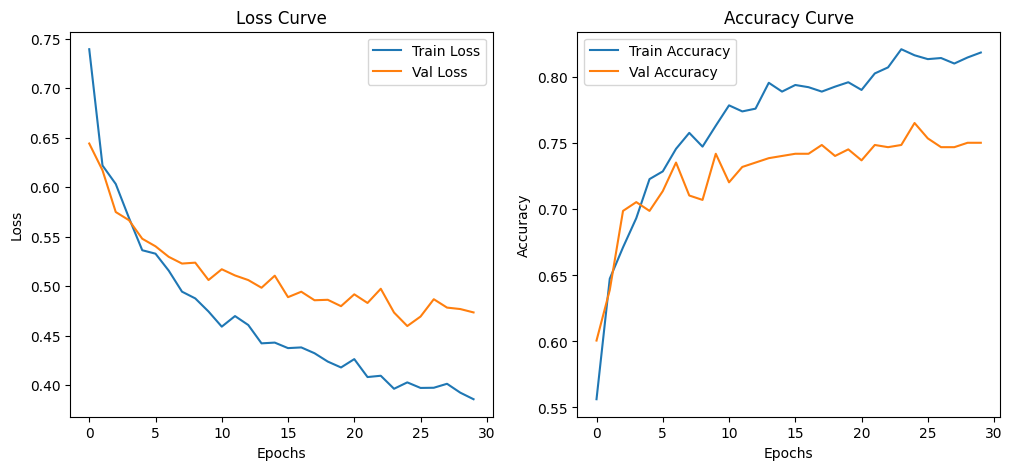

In [44]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()